<a href="https://colab.research.google.com/github/davidcassagne/cours-iaphys/blob/main/PINN_DC_intro_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics-informed neural networks (PINNs): an introductory crash-course

Version adaptée par David Cassagne à partir du workshop de Ben Moseley :
https://github.com/benmoseley/harmonic-oscillator-pinn-workshop.

By Ben Moseley, 2022

This workshop builds upon my blog post on PINNs: https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/.

Read the seminal PINN papers [here](https://ieeexplore.ieee.org/document/712178) and [here](https://www.sciencedirect.com/science/article/pii/S0021999118307125).


## Workshop goals

By the end of this workshop, you should be able to:
- code a PINN from scratch in PyTorch
- understand the different types of scientific tasks PINNs can be used for
- understand in more detail how PINNs are trained and how to improve their convergence


## Task overview

We will be coding a PINN from scratch in PyTorch and using it solve simulation and inversion tasks related to the damped harmonic oscillator.


## Environment set up

First, use the code below to set up your python / Jupyter notebook environment. Using conda is not essential; the required python libraries are listed below.

**Ajout DC : inutile dans Colab**

```bash
conda create -n workshop python=3
conda activate workshop
conda install jupyter numpy matplotlib
conda install pytorch torchvision torchaudio -c pytorch
```

In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## Problem overview

We are going to use a PINN to solve problems related to the **damped harmonic oscillator**:

<img src="https://github.com/benmoseley/harmonic-oscillator-pinn-workshop/blob/main/oscillator.gif?raw=1" width="500">

We are interested in modelling the displacement of the mass on a spring (green box) over time.

This is a canonical physics problem, where the displacement, $u(t)$, of the oscillator as a function of time can be described by the following differential equation:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

where $m$ is the mass of the oscillator, $\mu$ is the coefficient of friction and $k$ is the spring constant.

**Ajout DC**

En français, $\mu$ est appelé le coefficient de frottement.

We will focus on solving the problem in the **under-damped state**, i.e. where the oscillation is slowly damped by friction (as displayed in the animation above).

Mathematically, this occurs when:

$$
\delta < \omega_0~,~~~~~\mathrm{where}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

**Ajout DC**

- $\delta$ est la constante d'amortissement (elle caractérise la décroissance exponentielle et elle est adimensionnée)
- $\omega_0$ est la pulsation propre non amortie

Furthermore, we consider the following initial conditions of the system:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

For this particular case, the exact solution is known and given by:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$



For a more detailed mathematical description of the harmonic oscillator, check out this blog post: https://beltoforion.de/en/harmonic_oscillator/.

## Workflow overview

There are **two scientific tasks** related to the harmonic oscillator we will use a PINN for:

>First, we will **simulate** the system using a PINN, given its initial conditions.

>Second, we will **invert** for underlying parameters of the system using a PINN, given some noisy observations of the oscillator's displacement.

>Finally, we will investigate how well the PINN **scales** to higher frequency oscillations and what can be done to improve its convergence.

## Initial setup

First, we define a few helper functions.

In [8]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

class FCN(nn.Module):
    """
    Réseau "fully-connected network" (FCN) simple pour PINN.

    Paramètres
    ----------
    n_input : int
        Dimension de l'entrée (pour l'oscillateur : 1, le temps t).
    n_output : int
        Dimension de la sortie (pour l'oscillateur : 1, la position u(t)).
    n_hidden : int
        Nombre de neurones par couche cachée.
    n_layers : int
        Nombre de couches cachées (bloc Linear + activation).
    """

    def __init__(
        self,
        n_input: int,
        n_output: int,
        n_hidden: int,
        n_layers: int,
    ):
        super().__init__()

        layers = []

        # 1) première couche cachée : n_input -> n_hidden
        layers.append(nn.Linear(n_input, n_hidden))
        layers.append(nn.Tanh())

        # 2) couches cachées restantes
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(n_hidden, n_hidden))
            layers.append(nn.Tanh())

        # 3) couche de sortie
        layers.append(nn.Linear(n_hidden, n_output))

        # On regroupe tout dans un seul Sequential
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Propagation avant.

        x : tenseur de taille (N, n_input)
        retourne : tenseur de taille (N, n_output)
        """
        return self.net(x)


**Ajout DC : Pour mémo, la version initiale de la définition du fully-connected network**

```
class FCN(nn.Module):
    "Defines a standard fully-connected network in PyTorch"

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        # Ajout DC : le réseau fully-connected est séparé en trois parties :
        # Partie 1 : fully-connected start (fcs)
        self.fcs = nn.Sequential(
            nn.Linear(N_INPUT, N_HIDDEN),
            nn.Tanh()
        )
        # Partie 2 : fully-connected hidden (fch)
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        # Partie 3 : fully-connected end (fce)
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
```





## Task 1: train a PINN to simulate the system

### Task

The first task is to use a PINN to **simulate** the system.

Specifically, our inputs and outputs are:

- Inputs: underlying differential equation and the initial conditions of the system
- Outputs: estimate of the solution, $u(t)$

### Approach

The PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

where $\theta$ are the free parameters of the PINN.

### Loss function

To simulate the system, the PINN is trained with the following loss function:

$$
\mathcal{L}(\theta)= (u_{\mathrm{PINN}}(t=0;\theta) - 1)^2 + \lambda_1 \left(\frac{d\,u_{\mathrm{PINN}}}{dt}(t=0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2
$$

For this task, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $t\in [0,1]$.

### Notes

The first two terms in the loss function represent the **boundary loss**, and tries to ensure that the solution learned by the PINN matches the initial conditions of the system, namely, $u(t=0)=1$ and $u'(t=0)=0$.

The second term in the loss function is called the **physics loss**, and and tries to ensure that the PINN solution obeys the underlying differential equation at a set of training points $\{t_i\}$ sampled over the entire domain.

The hyperparameters, $\lambda_1$ and $\lambda_2$, are used to balence the terms in the loss function, to ensure stability during training.

Autodifferentiation (`torch.autograd`) is used to calculate the gradients of the PINN with respect to its input required to evaluate the loss function. This is very powerful!

For more details on `torch.autograd`, check out [this](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#a-gentle-introduction-to-torch-autograd) tutorial.

In [9]:
torch.manual_seed(123)

# define a neural network to train
# TODO: write code here
pinn = FCN(n_input=1, n_output=1, n_hidden=32, n_layers=3)

# define boundary points, for the boundary loss
# TODO: write code here
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

### Ajout DC : Pourquoi utilise-t-on `.view(-1, 1)`

`torch.tensor(0.)` crée un **scalaire**.
Or, les réseaux fully-connected `nn.Linear` utilisés dans les PINNs attendent toujours une **entrée 2D** de forme **(batch_size, n_features)**.

Pour la condition initiale où $t = 0$, on veut donc un tenseur de forme **(1, 1)** :

* `1` = un seul point dans le batch,
* `1` = une seule variable d’entrée (le temps $t$).

Dans `.view(-1, 1)`, le `-1` signifie *“laisse PyTorch deviner la dimension restante”*. Ceci transforme donc le scalaire en un tenseur 2D de taille **(1, 1)**.

Cette mise en forme est importante car :

* elle permet au réseau d’accepter correctement le point $t = 0$,
* elle assure que `autograd` peut calculer les dérivées $u'(0)$ et $u''(0)$ nécessaires à la loss du PINN,
* elle garde la même structure que les autres ensembles de points (physique, observations), généralement aussi de forme `(N, 1)`.

In [10]:
# define training points over the entire domain, for the physics loss
# TODO: write code here
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# prepare to train the PINN
d, w0 = 2, 20
mu, k = 2*d, w0**2
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-3)

### Ajout DC : Calcul de la dérivée avec `torch.autograd.grad`

Dans la boucle suivante, l'utilisation de `torch.autograd.grad` va permettre de calculer la dérivée $\frac{du}{dt}$ du réseau au point correspondant à la condition initiale grâce à l'instruction suivante :

```
dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
```

Voici le rôle de chaque élément :

* **`u`** : la sortie du réseau $u(t)$, dont on veut la dérivée.
* **`t_boundary`** : l’entrée par rapport à laquelle on dérive (ici le point $t = 0$).
* **`torch.ones_like(u)`** : un “gradient de sortie” qui indique à PyTorch que l’on souhaite la dérivée complète de `u`. Autograd nécessite toujours un gradient sortant, même pour des scalaires.
* **`create_graph=True`** : permet de *conserver le graphe de calcul* afin de pouvoir dériver à nouveau (s'il est nécessaire pour d'obtenir $u''(t)$).
* **`[0]`** : `autograd.grad` renvoie une liste ; on récupère simplement le premier élément.

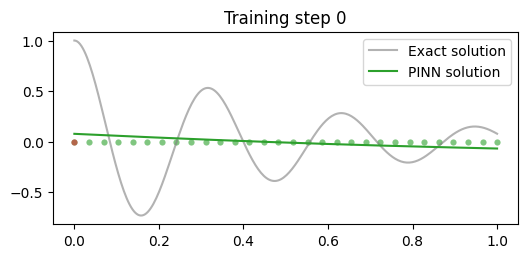

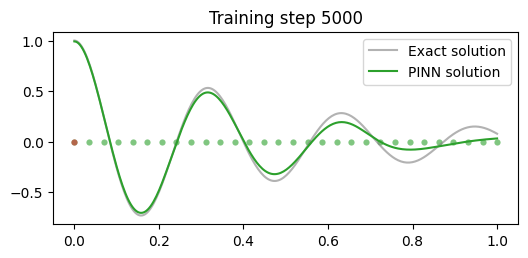

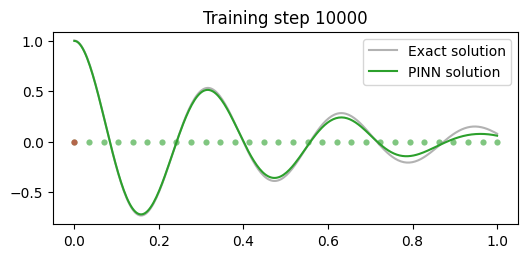

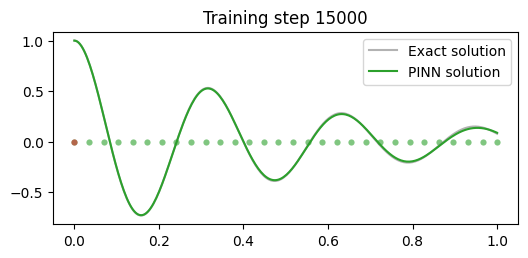

In [11]:
# train the PINN

for i in range(15001):
    optimiser.zero_grad()
    # Ajout DC : optimizer.zero_grad() met les gradients à zéro avant
    # une nouvelle étape d’apprentissage.
    # PyTorch accumule les gradients, donc si on ne les remet pas à zéro,
    #l’optimisation est incorrecte.

    # compute each term of the PINN loss function above
    # using the following hyperparameters:
    lambda1, lambda2 = 1e-1, 1e-4

    # compute boundary loss
    # TODO: write code here
    # Ajout DC : on se place sur la valeur du temps t=0 qui correspond à la
    # condition initiale
    u = pinn(t_boundary)
    loss1 = (torch.squeeze(u) - 1)**2
    # Ajout DC
    # On a dans u un tenseur de forme (1,1), la fonction torch.squeeze()
    # permet de convertir cela en un scalaire

    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2

    # compute physics loss
    # TODO: write code here
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # backpropagate joint loss, take optimiser step
    # TODO: write code here
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimiser.step()
    # ajout DC
    # loss.backward() calcule automatiquement les gradients de la loss
    # par rapport à tous les paramètres du réseau.
    # Il remonte le graphe de calcul créé pendant le forward, applique la
    # règle de la chaîne (ou règle de dérivation des fonctions composées),
    # et remplit param.grad pour chaque paramètre.
    # Ce n’est qu’après cet appel que l’optimiseur (optimizer.step()) peut mettre
    # à jour les poids.

    # plot the result as training progresses
    if i % 5000 == 0:
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = pinn(t_test).detach()
        # Ajout DC
        # .detach() renvoie un tenseur identique mais déconnecté du graphe
        # de calcul.
        # On l’utilise pour obtenir des valeurs “pures”, par exemple pour tracer
        # la solution, sans activer l’autograd ni affecter les gradients de l’entraînement.
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

## Task 2: train a PINN to invert for underlying parameters

### Task

The second task is to use a PINN to **invert** for underlying parameters.

Specifically, our inputs and outputs are:

- Inputs: noisy observations of the oscillator's displacement
- Outputs: estimate $\mu$, the coefficient of friction

### Approach

Similar to above, the PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

where $\theta$ are the free parameters of the PINN.

The key idea here is to also treat $\mu$ as a **learnable parameter** when training the PINN - so that we both simulate the solution and invert for this parameter.

### Loss function

The PINN is trained with a slightly different loss function:

$$
\mathcal{L}(\theta, \mu)= \frac{1}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2 + \frac{\lambda}{M} \sum^{M}_{j} \left( u_{\mathrm{PINN}}(t_{j};\theta) - u_{\mathrm{obs}}(t_{j}) \right)^2
$$

### Notes

There are two terms in the loss function here. The first is the **physics loss**, formed in the same way as above, which ensures the solution learned by the PINN is consistent with the know physics.

The second term is called the **data loss**, and makes sure that the solution learned by the PINN fits the (potentially noisy) observations of the solution that are available.

Note, we have removed the boundary loss terms, as we do not know these (i.e., we are only given the observed measurements of the system).

In this set up, the PINN parameters $\theta$ and $\mu$ are **jointly** learned during optimisation.

Again, autodifferentiation is our friend and will allow us to easily define this problem!

### Ajout DC

On voit qu'il y a deux paramètres $N$ et $M$.

$N$ correspond au nombre de *points de colocation*.

Les *points de colocation* sont les points où l’on impose l’équation différentielle dans une méthode de PINN.

La solution du réseau est forcée à satisfaire l’équation en ces points, ce qui remplace les schémas numériques traditionnels.

Ils sont à la base du calcul de la *physics loss*.

$M$ correspond au nombre de points $t_{j}$ qui ont donné lieu à une observation (résultats de mesure par exemple) et pour lesquels on connait la valeur $u_{\mathrm{obs}}(t_{j})$.

True value of mu: 4


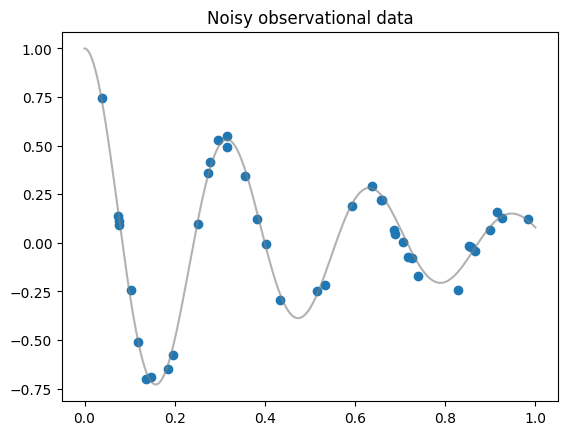

In [12]:
# first, create some noisy observational data
torch.manual_seed(123)
d, w0 = 2, 20
print(f"True value of mu: {2*d}")
t_obs = torch.rand(40).view(-1,1)
u_obs = exact_solution(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)

plt.figure()
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0])
t_test, u_exact = torch.linspace(0,1,300).view(-1,1), exact_solution(d, w0, t_test)
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.show()

<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-2230387784.py:61: SyntaxWarning: invalid escape sequence '\m'
  plt.title("$\mu$")


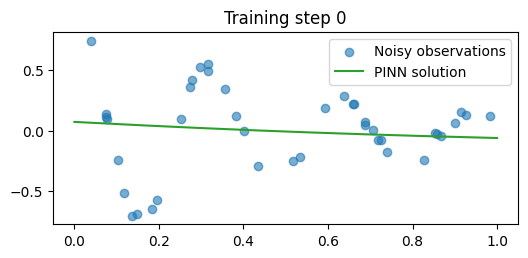

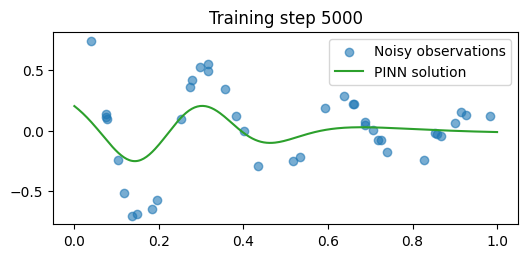

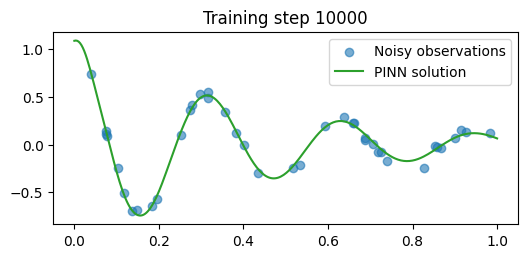

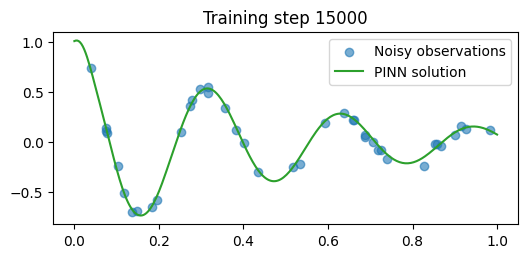

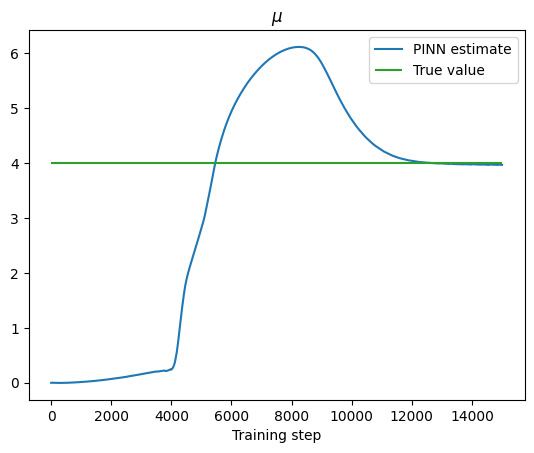

In [13]:
torch.manual_seed(123)

# define a neural network to train
pinn = FCN(n_input=1, n_output=1, n_hidden=32, n_layers=3)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# train the PINN
d, w0 = 2, 20
_, k = 2*d, w0**2
# Ajout DC : ici on a mis "_" pour signaler que le coefficient de frottement mu
# n'est pas connu et donc on ne lui affecte pas de valeur

# treat mu as a learnable parameter
# TODO: write code here
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
mus = []

# add mu to the optimiser
# TODO: write code here
optimiser = torch.optim.Adam(list(pinn.parameters())+[mu],lr=1e-3)
for i in range(15001):
    optimiser.zero_grad()

    # compute each term of the PINN loss function above
    # using the following hyperparameters:
    lambda1 = 1e4

    # compute physics loss
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss1 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # compute data loss
    # TODO: write code here
    u = pinn(t_obs)
    loss2 = torch.mean((u - u_obs)**2)

    # backpropagate joint loss, take optimiser step
    loss = loss1 + lambda1*loss2
    loss.backward()
    optimiser.step()

    # record mu value
    # TODO: write code here
    mus.append(mu.item())

    # plot the result as training progresses
    if i % 5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_obs[:,0], u_obs[:,0], label="Noisy observations", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

plt.figure()
plt.title("$\mu$")
plt.plot(mus, label="PINN estimate")
plt.hlines(2*d, 0, len(mus), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

## Task 3: investigate how well the PINN scales to higher frequency oscillations

### Task

The final task is to investigate how well the PINN **scales** to higher frequency oscillations and what can be done to improve its convergence.

Specifically, we go back to simulating the solution to the harmonic oscillator, and increase its frequency, $\omega_0$.

### To do

>To do: Go back to Task 1 above, and see what happens when you **increase** $\omega_0$ from 20 to 80.

You should find that the PINN struggles to converge, even if the number of physics training points is increased.

This is a harder problem for the PINN to solve, in part because of the **spectral bias** of neural networks, as well as the fact more training points are required.

### Approach: alternative "ansatz" formulation

To speed up convergence, one way is to **assume something** about the solution.

For example, suppose we know from our physics intuition that the solution is in fact sinusodial.

Then, instead of having the PINN directly approximate the solution to the differential equation, i.e.

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

We instead use the PINN as part of a mathematical ansatz of the solution, i.e.

$$
\hat u(t; \theta, \alpha, \beta) = u_{\mathrm{PINN}}(t;\theta)  \sin (\alpha t + \beta) \approx u(t)~,
$$

where $\alpha, \beta$ are treated as additional learnable parameters.

Comparing this ansatz to the exact solution

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))
$$

We see that now the PINN only needs to learn the exponential function, which should be a much easier problem.

Again, autodifferentiation allows us to easily differentiate through this ansatz to train the PINN!

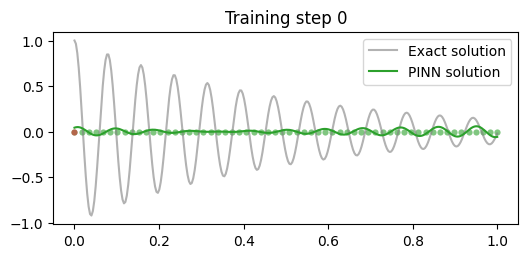

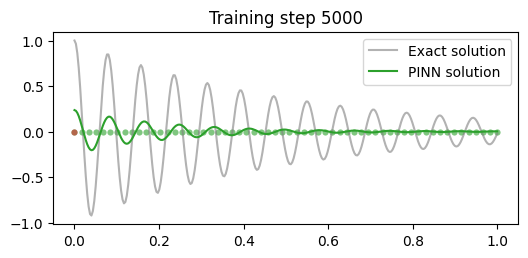

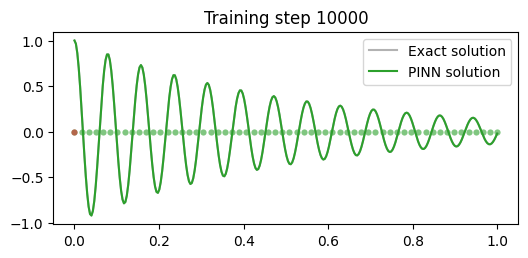

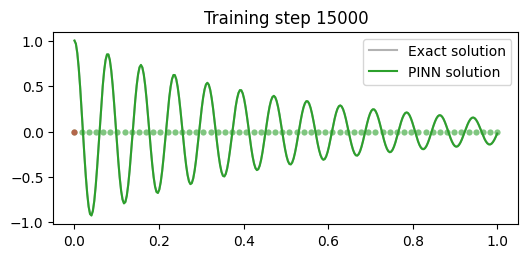

In [14]:
torch.manual_seed(123)

# define a neural network to train
pinn = FCN(n_input=1, n_output=1, n_hidden=32, n_layers=3)

# define additional a,b learnable parameters in the ansatz
# TODO: write code here
alpha = torch.nn.Parameter(70*torch.ones(1, requires_grad=True))
beta = torch.nn.Parameter(torch.ones(1, requires_grad=True))

# define boundary points, for the boundary loss
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,1,60).view(-1,1).requires_grad_(True)

# train the PINN
d, w0 = 2, 80 # note w0 is higher!
mu, k = 2*d, w0**2
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)
# add alpha et beta to the optimiser
# TODO: write code here
optimiser = torch.optim.Adam(list(pinn.parameters())+[alpha,beta],lr=1e-3)
for i in range(15001):
    optimiser.zero_grad()

    # compute each term of the PINN loss function above
    # using the following hyperparameters:
    lambda1, lambda2 = 1e-1, 1e-4

    # compute boundary loss
    # TODO: write code here (change to ansatz formulation)
    u = pinn(t_boundary) * torch.sin(alpha * t_boundary + beta)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2

    # compute physics loss
    # TODO: write code here (change to ansatz formulation)
    u = pinn(t_physics) * torch.sin(alpha * t_physics + beta)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # backpropagate joint loss, take optimiser step
    # TODO: write code here
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimiser.step()

    # plot the result as training progresses
    if i % 5000 == 0:
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = (pinn(t_test) * torch.sin(alpha * t_test + beta)).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

## Extensions

PINNs have been extended and improved in many ways since they have been proposed. Some things to try are:

- Try PINNs out for a different differential equation
- Try extending them to higher dimensions (e.g. 2D and 3D simulations)
- See how far you can push the inversion task: can you discover $m$, $\mu$ and $k$ simultaneously (and therefore, discover the entire underlying equation?)